In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

from utils import *

# Interger Linear Programming for Protein Folding
In this notebook, we show different integer linear programming (ILP) models for solving semplified versions of the protein folding problem.  
Predicting the three-dimensional structure of a protein, given its amino acid sequence, is a critical task in biochemistry and computational biology since it can help to better understand some diseases and the development of new drugs.
Since the search space is huge brute force is not an option and atomic-level modeling is computationally prohibitive, so many simplified models and approaches have been developed during the years. One of particular interest is the HP model.

## HP model
The HP model relies on three semplifications:
1. divide the 20 amino acids in two 2 groups:
    - Hydrophobic (non-polar) indicated with H
    - Hydrophilic (polar) indicated with P
Hence, our protein sequence becomes a binary string
2. Proteins in a cell are surrounded by water so the H amino acids are likely to be forced in the interior of the folded protein, while the P stay on the exterior.
3. Stability of the folding is maximized by the number of bonds between hydrophobic amino acids (H-H bonds)

In the first two sections of this notebook we are going to show different ILP models based on the HP model and for simplicity we are going to predict the 2-D structure of the protein by considering it as a binary string embed on a two-dimensional grid.

In [2]:
protein_sequence = "HHPHPHPH" #"HPPHHHPHPHPPHHPHHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

print("Offset: ", calculate_offset(protein_binary_sequence))

Protein sequence: HHPHPHPH
Protein binary sequence: 11010101
Protein length: 8
Offset:  1


## Basic Model
This 

In [51]:
def ILP_basic_formulation(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    grid_size = n*n
    offset = calculate_offset(binary_seq)

    # Set of indices
    model.I = RangeSet(0, n - 1)    # character in the sequence index
    model.I1 = RangeSet(0, n - 2)
    model.P = RangeSet(0, grid_size - 1)    # point on grid index
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision variables
    model.x = Var(model.I, model.P, within=Binary)
    model.h = Var(model.P, within=Binary)
    model.c = Var(model.P, model.P, within=Binary) 


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # Each amino acid in the sequence is assigned to exactly one point on the grid
    for i in model.I:
        model.constraints.add(expr = ( sum( model.x[i, p] for p in model.P ) == 1 ) )
    
    # Each point on the grid is assigned at most one amino acid in the sequence
    for i in model.I:
        for j in model.I:
            for p in model.P:
                if i != j:
                    model.constraints.add(expr = ( model.x[i, p] + model.x[j, p] <= 1 ) )
    
    # Adjacent amino acids in the sequence are assigned to neighboring points on the grid
    for i in model.I1:
        for p in model.P:
            model.constraints.add(expr = ( model.x[i, p] <= sum( model.x[i+1, q] for q in neighboring_set(p, n) ) ) )
            model.constraints.add(expr = ( model.x[i+1, p] <= sum( model.x[i, q] for q in neighboring_set(p, n) ) ) )

    # Constraints to detect contacts, i.e. edges (p,q) on the grid where neighboring points p and q
    # have been assigned non-adiancent characters in the sequence with value 1
    for p in model.P:
        model.constraints.add(expr = ( model.h[p] == sum( model.x[i, p] for i in model.H ) ) )
    for p in model.P:
        for q in model.P:
            if p != q:
                model.constraints.add(expr = ( model.h[p] + model.h[q] >= 2*model.c[p, q] ) )
                model.constraints.add(expr = ( model.h[p] + model.h[q] <= 1 + model.c[p, q] ) ) # added

    
    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.c[p, q] for p in model.P for q in model.P ) - offset ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", [[model.x[i, p]() for p in model.P] for i in model.I]) 
    else:
        print('Error in solving the model')

    return [[model.x[i, p]() for p in model.P] for i in model.I]



x = ILP_basic_formulation(protein_binary_sequence)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmplv_5y881.pyomo.lp
Reading time = 0.02 seconds
x4673: 12617 rows, 4673 columns, 36457 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 12617 rows, 4673 columns and 36457 nonzeros
Model fingerprint: 0xecf7a1f5
Variable types: 1 continuous, 4672 integer (4672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 83.0000000
Presolve removed 7695 rows and 2153 columns
Presolve time: 0.14s
Presolved: 4922 rows, 2520 columns, 17262 nonzeros
Variable types: 0 continuous, 2520 integer (2520 binary)

Root relaxation: objective 3.73

[33, 41, 40, 32, 31, 30, 38, 39]
[(4, 1), (5, 1), (5, 0), (4, 0), (3, 7), (3, 6), (4, 6), (4, 7)]


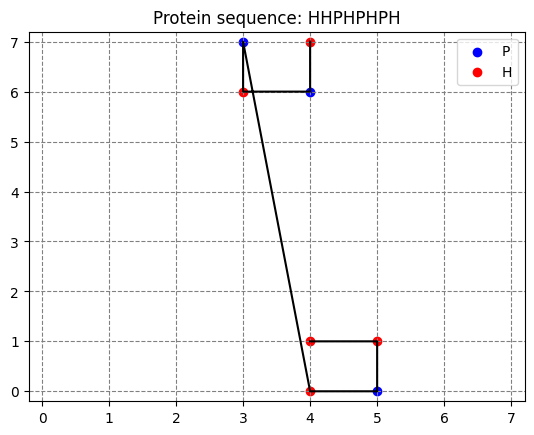

In [52]:
positions = []
pos = []
for i in range(len(x)):
    for p in range(len(x[i])):
        if x[i][p] == 1:
            positions.append((p // n, p % n))
            pos.append(p)
print(pos)
print(positions)

plot_folding(protein_binary_sequence, protein_sequence, positions, n-1)

## Protein folding on lattices : An integer programming approach
In this section we took inspiration from the paper [Protein folding on lattices : An integer programming approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2154543) and tried to reproduce their results.  
The aim is to predict 2D - HP protein folding on a rectangular lattice and formulate the model as an ILP problem.  

### Formulation
- $ s_k $ : amino acid that can be either hydrophobic (H) or hydrophilic (P)
- $ s_t $ and $ s_{t+1} $ are adjacent on the chain, with $ 1 \leq t \leq n-1 $
- $ H $ : set of hydrophobic amino acids
- Consider a $ (2n-1) * (2n-1) $ grid
- $ (i,j) $ : lattice point or vertex in the grid, $ 1 \leq i,j \leq 2n-1 $
- $ (i,j) $ and $ (u,v) $ are neighbours if one of the following is true:
    - $ u=i \qquad\text{and}\qquad v=j+1 \qquad\text{or}\qquad v=j-1 $
    - $ v=j \qquad\text{and}\qquad u=i+1 \qquad\text{or}\qquad u=i-1 $
- $ N_{ij} $ : set of adjacent vertices to vertex $ (i,j) $
- *Connected neighbours* : pair of amino acids that occure in successive positions in the chain
- *Topological neighbours* : pair of non-successive amino acids that are adjacent in the embedding  

- Define grid graph $ G = (V,E) $ where every edge is of the form $ ((i,j),(u,v)) $ where $ (u,v) \in N_{ij} $ with $ 1 \leq i,j \leq 2n-1 $
- First amino acid $ s_1 $ is placed at the center of the grid $ (n,n) $

### Goal
Place amino acids $ s_k $ at vertices $ (i,j) $ such that the following are satisfied
- each amino acid is placed at exactly one vertex
- each vertex has at most one amino acid
- amino acids adjacent on the chain must be placed at adjacent vertices  

And maximize the number of amino acids H that are topologically adjacent.

### Decision Variables
$$ x_{ij}^{k} =
\begin{cases}
      1 & \text{if $ s_k $ is placed on $ (i,j) $}\\
      0 & \text{otherwise}
    \end{cases}   
$$
$$ y_{ij}^{uv} =
\begin{cases}
      1 & \text{if $ s_{a},s_{b} \in H $ are placed on $ (i,j) $ and $ (u,v) $ s.t. $ (u,v) \in N_{ij} $}\\
      0 & \text{otherwise}
    \end{cases}   
$$

### Objective function
$$ max \sum_{((i,j),(u,v)) \in E} { y_{ij}^{uv} } $$

### Constraints
1. $ s_{1} $ is placed on $ (n,n) $
$$ x_{nn}^1 = 1 $$
2. Each vertex has at most one amino acid
$$ \sum_{k=1}^{n} {x_{ij}^{k}} \leq 1 \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 $$ 
3. Each amino acid is placed at exactly one vertex
$$ \sum_{i=1}^{2n-1} {\sum_{j=1}^{2n-1} {x_{ij}^{k}}} = 1 \qquad \forall k \qquad 1 \leq k \leq n $$ 
4. If amino acid $ k $ is placed at $ (i,j) $ then $ k+1 $ is placed at a vertex $ (u,v) \in N_{ij} $
$$ x_{ij}^{k} \leq \sum_{(u,v) \in N_{ij}} { x_{uv}^{k+1} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-1 $$
5. 6 If $ y_{ij}^{uv} = 1 $ only if two H amino acids are placed at neighbours vertices
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{ij}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
$$ y_{ij}^{uv} \leq \sum_{k \in H} { x_{uv}^{k} } \qquad \forall ((i,j),(u,v)) $$ 
7. $ x_{ij}^{k} $ is binary {0, 1}  
8. $ y_{ij}^{uv} $ is binary {0, 1}

### Additional constraints
Instead of just restricting the positions of neighbours amino acid $ s_k $ and $ s_{k+1} $, let's restrict the positions of $ s_k $ and $ s_{k+t} $ ($ s_{k-t} $) at distance $ t $  
The distance between two vertices is defined as $ d_{ij}^{uv} = |u-i| + |v-j| $  
The additional constraints are the following:  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k+t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad 1 \leq k \leq n-t $$  
$$ x_{ij}^{k} \leq \sum_{(u,v) : d_{ij}^{uv} \leq t} { x_{uv}^{k-t} } \qquad \forall (i,j) \qquad 1 \leq i,j \leq 2n-1 \qquad \forall k \qquad t+1 \leq k \leq n $$  
As stated in the paper the usefulness of these constraints still have to be explored.  
We added a boolean argument *additional_constr* that allows you to decide whether to include those additional constraints or not.  
In the experiments performed, no particular improvements have been noted in the optimal solutions found and adding those constraints slows down the algorithm.

In [5]:
def ILP_graph_formulation(binary_seq, grid_size, additional_constr, reduced, formulation=""):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    G = build_graph(binary_seq, grid_size=grid_size, reduced=reduced) # graph
    print("Number of edges:", G.number_of_edges())

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(0, grid_size - 1) 
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.I, within=Binary)
    model.y = Var(model.I, model.I, model.I, model.I, within=Binary)
    print("Dim x:", len(model.x))
    print("Dim y:", len(model.y))


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    if formulation != "alternative":
        # the first amino acid is placed on the center of the grid (n,n)
        model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )
    # in the alternative formulation we'll see later we don't have this constraint

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.I:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.I ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.I:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )

    # Additional Constraints
    # ensure that if k is placed on (i, j) then k+t (or k-t) must be placed on a vertex with distance <= t from (i, j)
    if additional_constr:
        for t in model.K:
            for i in model.I:
                for j in model.I:
                    for k in range(0, n - t):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) )
                    for k in range(t, n):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k-t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) ) 
                

    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.I] for i in model.I] for k in model.K]

Number of edges: 210
Dim x: 1800
Dim y: 50625
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpubcslspq.pyomo.lp
Reading time = 0.00 seconds
x52426: 1495 rows, 2011 columns, 9902 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1495 rows, 2011 columns and 9902 nonzeros
Model fingerprint: 0x11411392
Variable types: 1 continuous, 2010 integer (2010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1381 rows and 1906 columns
Presolve time: 0.04s
Presolved: 114 rows, 105 columns, 529 nonzeros
Variable types: 0 continuous, 105 integer (105 bina

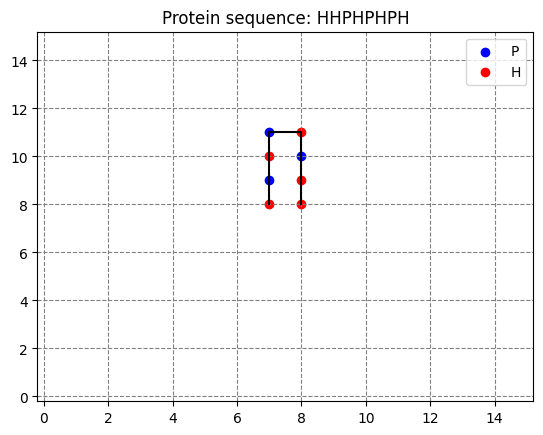

In [6]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=False)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Grid Size and Elimination of Variables

#### Method 1
It is possible to set a number of variables to zero by noting that the shortest path between any pair of vertices is either even or odd and if the distance between two amino acids in the sequence is even (odd) then their distance $ d_{ij}^{uv} $ in the grid must be even (odd).  

Moreover we can eliminate from the grid all the points with $ d_{nn}^{uv} \gt n $

Number of edges: 122
Dim x: 1800
Dim y: 50625
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpeohp86sv.pyomo.lp
Reading time = 0.00 seconds
x52426: 990 rows, 1923 columns, 7285 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 990 rows, 1923 columns and 7285 nonzeros
Model fingerprint: 0x87525a41
Variable types: 1 continuous, 1922 integer (1922 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 876 rows and 1818 columns
Presolve time: 0.03s
Presolved: 114 rows, 105 columns, 529 nonzeros
Variable types: 0 continuous, 105 integer (105 binary)

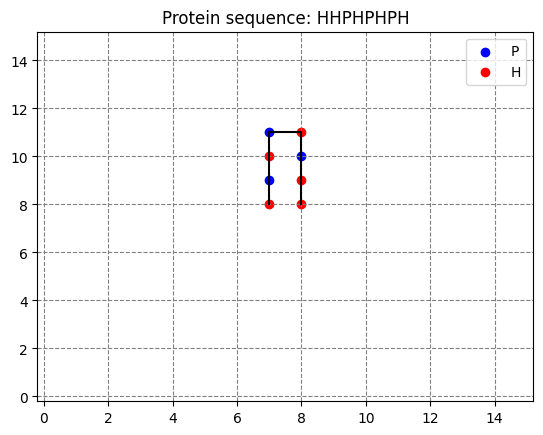

In [7]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

#### Method 2 : reduce the grid
Another approach to reduce the number of variables and speed-up the convergence is to reduce the size of the grid by considering a grid of vertices $ (i,j) $ such that  
$ n-p \leq i \leq 2n-1 \qquad\text{and}\qquad n-p \leq j \leq n+p \qquad\text{where}\qquad p = \frac{n}{2} $


Dim x: 864
Dim y: 11664
Number of edges: 195
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp5ewymay6.pyomo.lp
Reading time = 0.00 seconds
x12529: 1264 rows, 1060 columns, 7556 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1264 rows, 1060 columns and 7556 nonzeros
Model fingerprint: 0x31817312
Variable types: 1 continuous, 1059 integer (1059 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 1072 rows and 887 columns
Presolve time: 0.02s
Presolved: 192 rows, 173 columns, 920 nonzeros
Variable types: 0 continuous, 173 integer (173 binary

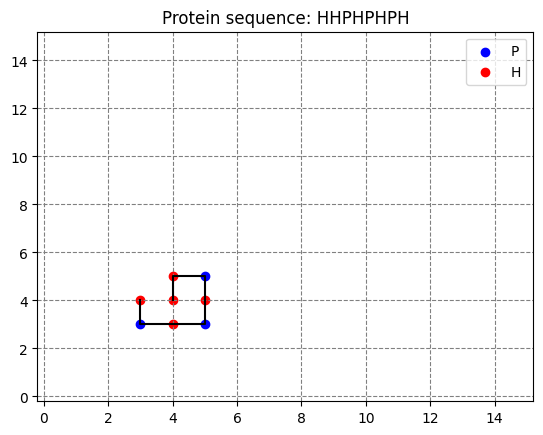

In [8]:
import networkx as nx

def ILP_graph_formulation_reduced_grid(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    p = int(n/2)

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(n - p, 2*n - 1) 
    model.J = RangeSet(n - p, n + p)
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.J, within=Binary)
    model.y = Var(model.I, model.J, model.I, model.J, within=Binary)
    print("Dim x:", len(model.x))
    print("Dim y:", len(model.y))

    G = nx.Graph()

    n = len(binary_seq)

    # add nodes
    for i in model.I:
        for j in model.J:
                G.add_node( (i, j) )

    # add edges
    for i, j in G.nodes():
         for u, v in G.nodes():
              if is_adjacent(i, j, u, v):
                   G.add_edge( (i, j), (u, v) )
    print("Number of edges:", G.number_of_edges())

    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # the first amino acid is placed on the center of the grid (n,n)
    model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.J:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.J ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.J:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.J] for i in model.I] for k in model.K]


grid_size = 2*n - 1
x = ILP_graph_formulation_reduced_grid(protein_binary_sequence)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Alternative formulation
This alternative formulation differs from the original because instead of anchoring the first amino acid $ s_{1} $ to the center of the grid $ (n,n) $ we just require that it is placed somewhere with the constraint:
$$ \sum_{i} { \sum_{j} { x_{ij}^{k} } } = 1 $$
Moreover, in this case we only require a $ n*n $ grid. The disadvantage is that with this formulation we cannot eliminate variables like before. Hence, as we can see by running the following code, it is slower than the previous cases (ceteris paribus).

Number of edges: 56
Dim x: 512
Dim y: 4096
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmphpkn8tgu.pyomo.lp
Reading time = 0.00 seconds
x4609: 437 rows, 569 columns, 2733 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 437 rows, 569 columns and 2733 nonzeros
Model fingerprint: 0x0f40d7b5
Variable types: 1 continuous, 568 integer (568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 436 rows, 568 columns, 2732 nonzeros
Variable types: 0 continuous, 568 integer (568 binary)

Root rela

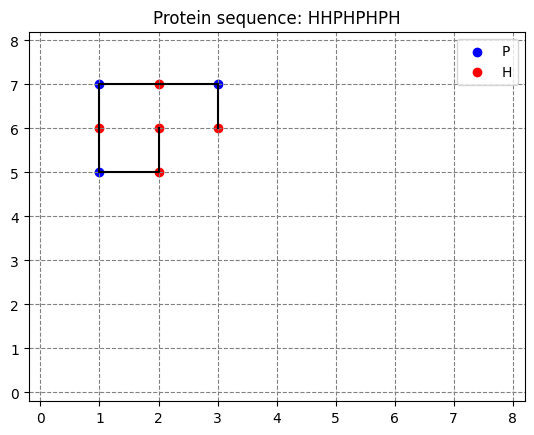

In [8]:
# No reduction of variables

grid_size = n
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=False, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

Number of edges: 36
Dim x: 648
Dim y: 6561
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpb1v40yd6.pyomo.lp
Reading time = 0.00 seconds
x7210: 337 rows, 685 columns, 2408 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 337 rows, 685 columns and 2408 nonzeros
Model fingerprint: 0xdf1f0066
Variable types: 1 continuous, 684 integer (684 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -1.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 336 rows, 684 columns, 2407 nonzeros
Variable types: 0 continuous, 684 integer (684 binary)

Root rela

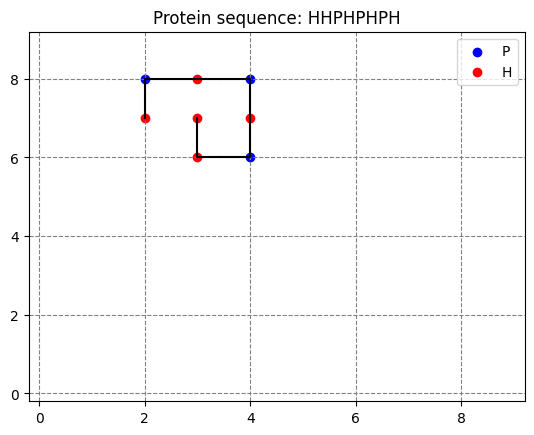

In [62]:
# We increase the grid to (n+1)x(n+1) and we simplify in an analogous way to the original formulation

grid_size = n+1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

## Protein structure prediction using the 3D-HP side chain model
In this section we took inspiration and tried to reproduce the results from the paper [An integer programming model for protein structure prediction using the 3D-HP side chain model](https://www.sciencedirect.com/science/article/pii/S0166218X15003078). The 3D-HP model they considered assumes that each amino acid is represented by a backbone and a side chain. All elements (backbone or side chain) occupy only one position in a cubic lattice and the side chain is always positioned in the neighbourhood of its respective backbone. Also successive backbones are positioned in neighbourhood points to maintain the sequence. As in the previous 2-D model, we are considering amino acid side chains to be either hydrophobic (H) or hydrophilic (P) according to the HP model.  
The objective is to maximize the number of non-local hydrophobic side chain contacts in order to find the most stable folding configuration. 